### Neural Net with TensorFlow

In [ ]:
# Install tensorflow and protobuf -- run once!
# anaconda install instructions: https://www.tensorflow.org/install/install_mac

# # For chase's macbook, the following shell commands worked (take out ! if in terminal)
# !conda create -n tensorflow python=2.7
# !source activate tensorflow
# !pip install --ignore-installed --upgrade https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.4.0-py2-none-any.whl

# Remember to activate container when you want to use package

In [184]:
import sys, csv, json
import requests
import numpy as np
import pandas as pd
import csv, json
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

In [185]:
# Import Dataset Pickle
import pickle
import pandas as pd
dfNN_raw = pickle.load(open('NN_pickles.p', 'rb'))
print dfNN_raw.head(5)
# pd.options.display.max_rows = len(dfNN_raw)
# dfNN_raw.head(len(dfNN_raw))


  prev_price compound    neg    neu   pos next_price
0     307.15   0.7424      0   0.69  0.31     307.26
1        463  -0.7003  0.209  0.791     0     467.29
2     465.01  -0.1759  0.253  0.747     0     461.57
3     464.53        0      0      1     0     465.01
4        462        0      0      1     0        465


In [186]:
# Python
# import tensorflow as tf
# hello = tf.constant('Hello, TensorFlow!')
# sess = tf.Session()
# print(sess.run(hello))

In [187]:
dfNN = (dfNN_raw - dfNN_raw.mean()) / (dfNN_raw.max() - dfNN_raw.min())
dfNN.reset_index(inplace=True)
del dfNN['index']
dfNN.head(5)
print dfNN.head(5), type(dfNN)

  prev_price   compound       neg       neu       pos next_price
0  -0.205992   0.342107 -0.041533 -0.237517   0.30568  -0.205298
1   0.468625   -0.46241  0.214909  -0.11359 -0.110987   0.487412
2   0.477325   -0.16998  0.268896 -0.167578 -0.110987   0.462653
3   0.475247 -0.0718898 -0.041533  0.142851 -0.110987   0.477543
4   0.464296 -0.0718898 -0.041533  0.142851 -0.110987     0.4775 <class 'pandas.core.frame.DataFrame'>


In [188]:
dfNN = pd.DataFrame(dfNN)
dfNN = dfNN.dropna()

In [189]:
# Taking straight from LSTM Stock Model
num_epochs = 1000

batch_size = 1

total_series_length = len(dfNN.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 6432
The current configuration gives us 2144 batches of 1 observations each one looking 3 steps in the past


In [190]:
# Split Training-Test
dfTrain = dfNN[dfNN.index < num_batches*batch_size*truncated_backprop_length]
print dfTrain

for i in range(min_test_size,len(dfNN.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(dfNN.index)-i
        break

dfTest =  dfNN[dfNN.index >= test_first_idx]

     prev_price    compound        neg         neu          pos next_price
0     -0.205992    0.342107  -0.041533   -0.237517      0.30568  -0.205298
1      0.468625    -0.46241   0.214909    -0.11359    -0.110987   0.487412
2      0.477325    -0.16998   0.268896   -0.167578    -0.110987   0.462653
3      0.475247  -0.0718898  -0.041533    0.142851    -0.110987   0.477543
4      0.464296  -0.0718898  -0.041533    0.142851    -0.110987     0.4775
5      0.477325  -0.0146195  -0.041533    -0.17494     0.237131   0.462653
6      0.472953  -0.0146195   0.203866   -0.368805      0.18068   0.455857
7      0.462435  -0.0718898  -0.041533    0.142851    -0.110987   0.451701
8      0.472953  -0.0718898  -0.041533    0.142851    -0.110987   0.455857
9      0.472953    0.212845  -0.041533   0.0115631    0.0328301   0.455857
10     0.457197  -0.0718898  -0.041533    0.142851    -0.110987    0.46209
11     0.457197  -0.0718898  -0.041533    0.142851    -0.110987    0.46209
12     0.531216    0.1522

In [191]:
xTrain = dfTrain[['prev_price','neu','neg','pos']].as_matrix()[::-1]
yTrain = dfTrain['next_price'].as_matrix()[::-1]

print xTrain
print yTrain
# xTrain = dfTrain[['prev_price','neu','neg','pos']]
# yTrain = dfTrain['next_price']

[[-0.24399776827917891 -0.0939583371059405 0.10693326826980906
  -0.014212921433712958]
 [-0.24399776827917891 0.14285147884497984 -0.04153298939890261
  -0.11098711498210005]
 [-0.21741998280605976 0.0845692702560228 -0.01883360289583513
  -0.07133657734769144]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]]
[-0.245338122498907 -0.245338122498907 -0.24377981585878922 ...,
 0.46265252766125237 0.487412288720901 -0.20529829910699288]


In [192]:
xTrain.shape


(6427, 4)

In [193]:
xTest = dfTest[['prev_price','neu','neg','pos']].as_matrix()
yTest = dfTest['next_price'].as_matrix()

In [194]:
yTest.shape


(107,)

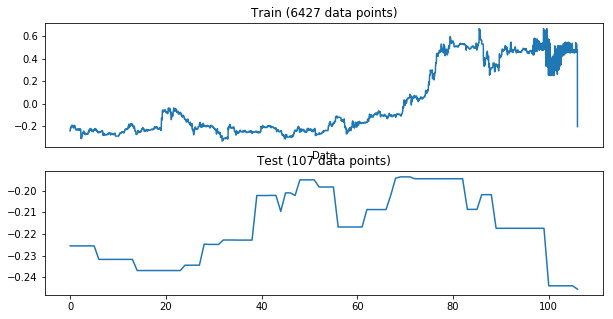

In [195]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig,ax = plt.subplots(2,1, figsize = (10,5))
ax[0].plot(xTrain[:,0])
ax[0].set_title('Train (' +str(len(xTrain))+' data points)')
ax[0].set_xlabel('Date')
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%y'))

ax[1].plot(xTest[:,0])
ax[1].set_title('Test (' +str(len(xTest))+' data points)')

# plt.figure(figsize=(25,5))
# plt.plot(xTrain[:,0])
# plt.title('Train (' +str(len(xTrain))+' data points)')
# plt.xaxis.set_major_locator(mdates.MonthLocator())
# plt.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%y'))

plt.show()

# plt.figure(figsize=(10,3))
# plt.plot(xTest[:,0])
# plt.title('Test (' +str(len(xTest))+' data points)')
# plt.show()

In [196]:
# LOAD DATA^

In [197]:
# SETUP NET

In [198]:
tf.reset_default_graph()


In [199]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

In [200]:
# irrelevant if no more classes (random array unif distribution) 
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

In [201]:
# unpack and create edge from input to hidden layer
labels_series = tf.unstack(batchY_placeholder, axis=1)


In [202]:
# forward pass
cell = tf.contrib.rnn.BasicLSTMCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [203]:
# talk about permutations and how data goes through nodes
states_series = tf.transpose(states_series,[1,0,2])


In [204]:
# backwards pass starting point
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

In [205]:
# bp weights and biases
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

In [206]:
prediction = tf.matmul(last_state,weight) + bias
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))
train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)


In [243]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    num_epochs = 50
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            try:
                batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
                batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
            except:
                print xTrain, start_idx, end_idx, batch_size, truncated_backprop_length, num_features
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
#             if type(loss) != float(1):
#                 print _loss,_train_step,_pred,_last_label,_prediction
            
           
            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one
        

Epoch 0
Step 0 - Loss: 0.050307
Step 50 - Loss: 0.000548
Step 100 - Loss: 0.000162
Step 150 - Loss: 0.000243
Step 200 - Loss: 0.000016
Step 250 - Loss: 0.000019
Step 300 - Loss: 0.000001
Step 350 - Loss: 0.000008
Step 400 - Loss: 0.000114
Step 450 - Loss: 0.000004
Step 500 - Loss: 0.005462
Step 550 - Loss: 0.001135
Step 600 - Loss: 0.000000
Step 650 - Loss: 0.000228
Step 700 - Loss: 0.000052
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000010
Step 850 - Loss: 0.000136
Step 900 - Loss: 0.000029
Step 950 - Loss: 0.002119
Step 1000 - Loss: 0.000043
Step 1050 - Loss: 0.000034
Step 1100 - Loss: 0.000569
Step 1150 - Loss: 0.000038
Step 1200 - Loss: 0.000419
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000045
Step 1350 - Loss: 0.000437
Step 1400 - Loss: 0.000005
Step 1450 - Loss: 0.000660
Step 1500 - Loss: 0.000424
Step 1550 - Loss: 0.003545
Step 1600 - Loss: 0.001607
Step 1650 - Loss: 0.000090
Step 1700 - Loss: 0.000240
Step 1750 - Loss: 0.002355
Step 1800 - Loss: 0.000806
Step 1850 - Loss

Step 100 - Loss: 0.000021
Step 150 - Loss: 0.000070
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000000
Step 350 - Loss: 0.000006
Step 400 - Loss: 0.000161
Step 450 - Loss: 0.000097
Step 500 - Loss: 0.005801
Step 550 - Loss: 0.001107
Step 600 - Loss: 0.000021
Step 650 - Loss: 0.000022
Step 700 - Loss: 0.000111
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000051
Step 900 - Loss: 0.000008
Step 950 - Loss: 0.001012
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000141
Step 1100 - Loss: 0.000522
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000038
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000109
Step 1350 - Loss: 0.000256
Step 1400 - Loss: 0.000014
Step 1450 - Loss: 0.000317
Step 1500 - Loss: 0.000003
Step 1550 - Loss: 0.000820
Step 1600 - Loss: 0.001248
Step 1650 - Loss: 0.000191
Step 1700 - Loss: 0.000066
Step 1750 - Loss: 0.002704
Step 1800 - Loss: 0.000494
Step 1850 - Loss: 0.000033
Step 1900 - Loss: 0.000312
Step 1950 - Loss: 0

Step 50 - Loss: 0.000172
Step 100 - Loss: 0.000030
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000001
Step 300 - Loss: 0.000000
Step 350 - Loss: 0.000005
Step 400 - Loss: 0.000163
Step 450 - Loss: 0.000099
Step 500 - Loss: 0.005482
Step 550 - Loss: 0.001197
Step 600 - Loss: 0.000029
Step 650 - Loss: 0.000010
Step 700 - Loss: 0.000080
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000056
Step 900 - Loss: 0.000010
Step 950 - Loss: 0.000722
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000157
Step 1100 - Loss: 0.000395
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000013
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000113
Step 1350 - Loss: 0.000262
Step 1400 - Loss: 0.000010
Step 1450 - Loss: 0.000163
Step 1500 - Loss: 0.000007
Step 1550 - Loss: 0.000535
Step 1600 - Loss: 0.001301
Step 1650 - Loss: 0.000319
Step 1700 - Loss: 0.000008
Step 1750 - Loss: 0.002118
Step 1800 - Loss: 0.000380
Step 1850 - Loss: 0.000062
Step 1900 - Loss: 0.0

Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000002
Step 300 - Loss: 0.000001
Step 350 - Loss: 0.000004
Step 400 - Loss: 0.000151
Step 450 - Loss: 0.000099
Step 500 - Loss: 0.005156
Step 550 - Loss: 0.001226
Step 600 - Loss: 0.000037
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000054
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000060
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000565
Step 1000 - Loss: 0.000006
Step 1050 - Loss: 0.000166
Step 1100 - Loss: 0.000317
Step 1150 - Loss: 0.000005
Step 1200 - Loss: 0.000008
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000112
Step 1350 - Loss: 0.000272
Step 1400 - Loss: 0.000007
Step 1450 - Loss: 0.000071
Step 1500 - Loss: 0.000032
Step 1550 - Loss: 0.000375
Step 1600 - Loss: 0.001302
Step 1650 - Loss: 0.000445
Step 1700 - Loss: 0.000000
Step 1750 - Loss: 0.001689
Step 1800 - Loss: 0.000366
Step 1850 - Loss: 0.000093
Step 1900 - Loss: 0.000233
Step 1950 - Loss: 0.000532
Step 2000 - Loss: 

Step 50 - Loss: 0.000100
Step 100 - Loss: 0.000041
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000001
Step 300 - Loss: 0.000001
Step 350 - Loss: 0.000003
Step 400 - Loss: 0.000129
Step 450 - Loss: 0.000099
Step 500 - Loss: 0.004891
Step 550 - Loss: 0.001227
Step 600 - Loss: 0.000043
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000038
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000061
Step 900 - Loss: 0.000018
Step 950 - Loss: 0.000454
Step 1000 - Loss: 0.000006
Step 1050 - Loss: 0.000166
Step 1100 - Loss: 0.000283
Step 1150 - Loss: 0.000006
Step 1200 - Loss: 0.000008
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000106
Step 1350 - Loss: 0.000283
Step 1400 - Loss: 0.000004
Step 1450 - Loss: 0.000026
Step 1500 - Loss: 0.000051
Step 1550 - Loss: 0.000266
Step 1600 - Loss: 0.001160
Step 1650 - Loss: 0.000523
Step 1700 - Loss: 0.000005
Step 1750 - Loss: 0.001312
Step 1800 - Loss: 0.000374
Step 1850 - Loss: 0.000123
Step 1900 - Loss: 0.0

Step 50 - Loss: 0.000091
Step 100 - Loss: 0.000037
Step 150 - Loss: 0.000010
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000001
Step 300 - Loss: 0.000002
Step 350 - Loss: 0.000003
Step 400 - Loss: 0.000116
Step 450 - Loss: 0.000098
Step 500 - Loss: 0.004716
Step 550 - Loss: 0.001206
Step 600 - Loss: 0.000043
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000035
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000062
Step 900 - Loss: 0.000019
Step 950 - Loss: 0.000388
Step 1000 - Loss: 0.000005
Step 1050 - Loss: 0.000165
Step 1100 - Loss: 0.000264
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000007
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000104
Step 1350 - Loss: 0.000294
Step 1400 - Loss: 0.000003
Step 1450 - Loss: 0.000008
Step 1500 - Loss: 0.000060
Step 1550 - Loss: 0.000205
Step 1600 - Loss: 0.001048
Step 1650 - Loss: 0.000543
Step 1700 - Loss: 0.000015
Step 1750 - Loss: 0.001027
Step 1800 - Loss: 0.000390
Step 1850 - Loss: 0.000139
Step 1900 - Loss: 0.0

Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000001
Step 300 - Loss: 0.000002
Step 350 - Loss: 0.000003
Step 400 - Loss: 0.000109
Step 450 - Loss: 0.000096
Step 500 - Loss: 0.004574
Step 550 - Loss: 0.001184
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000034
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000009
Step 850 - Loss: 0.000062
Step 900 - Loss: 0.000019
Step 950 - Loss: 0.000346
Step 1000 - Loss: 0.000004
Step 1050 - Loss: 0.000162
Step 1100 - Loss: 0.000248
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000007
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000103
Step 1350 - Loss: 0.000300
Step 1400 - Loss: 0.000002
Step 1450 - Loss: 0.000002
Step 1500 - Loss: 0.000066
Step 1550 - Loss: 0.000165
Step 1600 - Loss: 0.000974
Step 1650 - Loss: 0.000560
Step 1700 - Loss: 0.000026
Step 1750 - Loss: 0.000827
Step 1800 - Loss: 0.000405
Step 1850 - Loss: 0.000150
Step 1900 - Loss: 0.000151
Step 1950 - Loss: 0.000438
Step 2000 - Loss: 0.000009
Step 2050 - Loss:

Step 150 - Loss: 0.000009
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000001
Step 300 - Loss: 0.000002
Step 350 - Loss: 0.000003
Step 400 - Loss: 0.000104
Step 450 - Loss: 0.000094
Step 500 - Loss: 0.004453
Step 550 - Loss: 0.001164
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000034
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000010
Step 850 - Loss: 0.000063
Step 900 - Loss: 0.000020
Step 950 - Loss: 0.000314
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000159
Step 1100 - Loss: 0.000234
Step 1150 - Loss: 0.000011
Step 1200 - Loss: 0.000006
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000101
Step 1350 - Loss: 0.000304
Step 1400 - Loss: 0.000002
Step 1450 - Loss: 0.000000
Step 1500 - Loss: 0.000071
Step 1550 - Loss: 0.000138
Step 1600 - Loss: 0.000917
Step 1650 - Loss: 0.000570
Step 1700 - Loss: 0.000037
Step 1750 - Loss: 0.000687
Step 1800 - Loss: 0.000417
Step 1850 - Loss: 0.000159
Step 1900 - Loss: 0.000142
Step 1950 - Loss: 0.000428
Step 2000 - Loss: 

Step 150 - Loss: 0.000011
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000003
Step 350 - Loss: 0.000003
Step 400 - Loss: 0.000101
Step 450 - Loss: 0.000092
Step 500 - Loss: 0.004354
Step 550 - Loss: 0.001146
Step 600 - Loss: 0.000038
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000034
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000010
Step 850 - Loss: 0.000064
Step 900 - Loss: 0.000020
Step 950 - Loss: 0.000290
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000156
Step 1100 - Loss: 0.000224
Step 1150 - Loss: 0.000013
Step 1200 - Loss: 0.000006
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000100
Step 1350 - Loss: 0.000307
Step 1400 - Loss: 0.000001
Step 1450 - Loss: 0.000001
Step 1500 - Loss: 0.000074
Step 1550 - Loss: 0.000120
Step 1600 - Loss: 0.000877
Step 1650 - Loss: 0.000573
Step 1700 - Loss: 0.000046
Step 1750 - Loss: 0.000583
Step 1800 - Loss: 0.000429
Step 1850 - Loss: 0.000166
Step 1900 - Loss: 0.000134
Step 1950 - Loss: 0.000420
Step 2000 - Loss: 

Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000003
Step 350 - Loss: 0.000003
Step 400 - Loss: 0.000098
Step 450 - Loss: 0.000090
Step 500 - Loss: 0.004277
Step 550 - Loss: 0.001130
Step 600 - Loss: 0.000036
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000034
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000010
Step 850 - Loss: 0.000064
Step 900 - Loss: 0.000020
Step 950 - Loss: 0.000274
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000154
Step 1100 - Loss: 0.000215
Step 1150 - Loss: 0.000015
Step 1200 - Loss: 0.000006
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000099
Step 1350 - Loss: 0.000308
Step 1400 - Loss: 0.000001
Step 1450 - Loss: 0.000003
Step 1500 - Loss: 0.000077
Step 1550 - Loss: 0.000108
Step 1600 - Loss: 0.000847
Step 1650 - Loss: 0.000578
Step 1700 - Loss: 0.000053
Step 1750 - Loss: 0.000505
Step 1800 - Loss: 0.000443
Step 1850 - Loss: 0.000172
Step 1900 - Loss: 0.000128
Step 1950 - Loss: 0.000412
Step 2000 - Loss: 

Step 100 - Loss: 0.000020
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000003
Step 350 - Loss: 0.000003
Step 400 - Loss: 0.000096
Step 450 - Loss: 0.000088
Step 500 - Loss: 0.004211
Step 550 - Loss: 0.001115
Step 600 - Loss: 0.000034
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000034
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000010
Step 850 - Loss: 0.000064
Step 900 - Loss: 0.000020
Step 950 - Loss: 0.000263
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000151
Step 1100 - Loss: 0.000208
Step 1150 - Loss: 0.000017
Step 1200 - Loss: 0.000005
Step 1250 - Loss: 0.000000
Step 1300 - Loss: 0.000097
Step 1350 - Loss: 0.000309
Step 1400 - Loss: 0.000001
Step 1450 - Loss: 0.000005
Step 1500 - Loss: 0.000079
Step 1550 - Loss: 0.000099
Step 1600 - Loss: 0.000821
Step 1650 - Loss: 0.000587
Step 1700 - Loss: 0.000059
Step 1750 - Loss: 0.000443
Step 1800 - Loss: 0.000457
Step 1850 - Loss: 0.000177
Step 1900 - Loss: 0.000122
Step 1950 - Loss: 0

Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000003
Step 350 - Loss: 0.000003
Step 400 - Loss: 0.000094
Step 450 - Loss: 0.000087
Step 500 - Loss: 0.004154
Step 550 - Loss: 0.001102
Step 600 - Loss: 0.000032
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000035
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000010
Step 850 - Loss: 0.000064
Step 900 - Loss: 0.000020
Step 950 - Loss: 0.000254
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000149
Step 1100 - Loss: 0.000201
Step 1150 - Loss: 0.000019
Step 1200 - Loss: 0.000005
Step 1250 - Loss: 0.000001
Step 1300 - Loss: 0.000096
Step 1350 - Loss: 0.000310
Step 1400 - Loss: 0.000001
Step 1450 - Loss: 0.000007
Step 1500 - Loss: 0.000080
Step 1550 - Loss: 0.000092
Step 1600 - Loss: 0.000798
Step 1650 - Loss: 0.000599
Step 1700 - Loss: 0.000065
Step 1750 - Loss: 0.000392
Step 1800 - Loss: 0.000471
Step 1850 - Loss: 0.000180
Step 1900 - Loss: 0.000119
Step 1950 - Loss: 0.000397
Step 2000 - Loss: 

Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000003
Step 350 - Loss: 0.000003
Step 400 - Loss: 0.000093
Step 450 - Loss: 0.000085
Step 500 - Loss: 0.004107
Step 550 - Loss: 0.001089
Step 600 - Loss: 0.000030
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000036
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000010
Step 850 - Loss: 0.000064
Step 900 - Loss: 0.000021
Step 950 - Loss: 0.000248
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000146
Step 1100 - Loss: 0.000195
Step 1150 - Loss: 0.000020
Step 1200 - Loss: 0.000005
Step 1250 - Loss: 0.000001
Step 1300 - Loss: 0.000095
Step 1350 - Loss: 0.000311
Step 1400 - Loss: 0.000000
Step 1450 - Loss: 0.000010
Step 1500 - Loss: 0.000081
Step 1550 - Loss: 0.000086
Step 1600 - Loss: 0.000775
Step 1650 - Loss: 0.000612
Step 1700 - Loss: 0.000069
Step 1750 - Loss: 0.000350
Step 1800 - Loss: 0.000483
Step 1850 - Loss: 0.000182
Step 1900 - Loss: 0.000116
Step 1950 - Loss: 0.000392
Step 2000 - Loss: 

## WOOO!

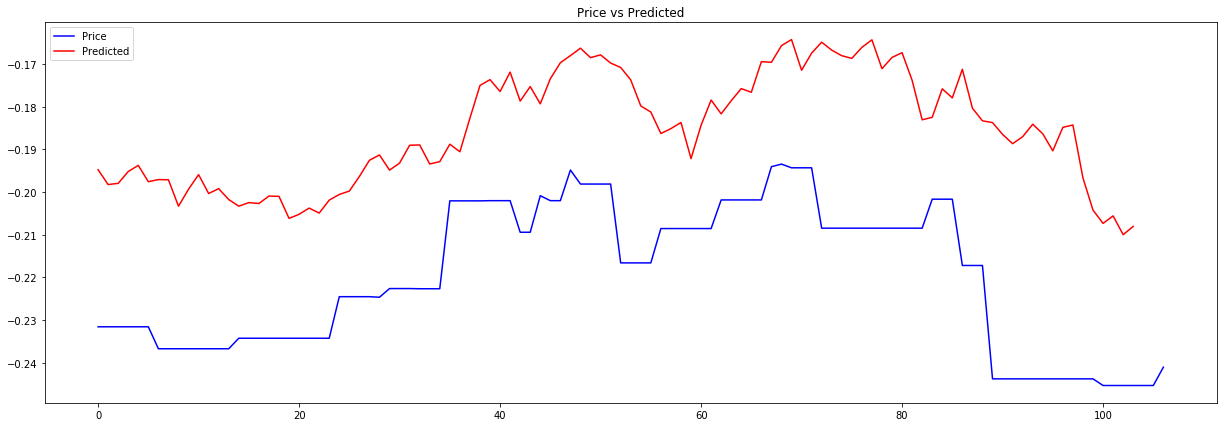

In [245]:
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()

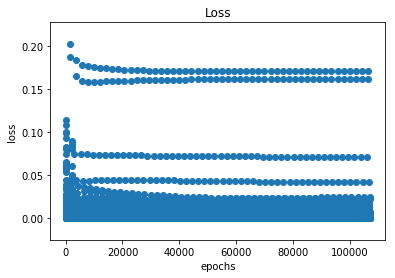

In [209]:
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)), y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### Now we split the data into disjoint time intervals

In [231]:
dfNN_sorted = pickle.load(open('NN_pickled_time.p', 'rb'))
dfNN_sorted = dfNN_sorted.sort_values('datetime')
dfNN_mean = dfNN_sorted.mean()
dfNN_max = dfNN_sorted.max()
dfNN_min = dfNN_sorted.min()
dfNN_sorted = (dfNN_sorted - dfNN_mean) / (dfNN_max - dfNN_min)
dfNN_sorted.reset_index(inplace=True)
del dfNN_sorted['index']
dfNN_sorted.head(5)
print dfNN_sorted.head(5), type(dfNN)


  prev_price    compound        neg        neu        pos next_price  datetime
0  -0.245556  0.00428477  -0.041533  0.0894772 -0.0525194  -0.241053 -0.566531
1  -0.243998  -0.0718898  -0.041533   0.142851  -0.110987  -0.245338  -0.56593
2  -0.243998  -0.0975415   0.106933 -0.0939583 -0.0142129  -0.245338  -0.56593
3  -0.243998   -0.134988  0.0652155 -0.0350626 -0.0330301  -0.245338  -0.56593
4  -0.243998    -0.16669  0.0382216  0.0630969  -0.110987  -0.245338  -0.56593 <class 'pandas.core.frame.DataFrame'>


In [232]:
dfNN_sorted = pd.DataFrame(dfNN_sorted)
dfNN_sorted = dfNN_sorted.dropna()

In [233]:
Train2 = dfNN_sorted.iloc[:4000, :]
Test2 = dfNN_sorted.iloc[4000:, :]
# Test2 = pd.DataFrame(Test2, columns = ['prev_price', 'compound', 'neg', 'neu','pos','next_price'])

print len(dfNN), len(Train2), dfNN.head(3), Test2.head(4)

xTrain2 = Train2[['prev_price','neu','neg','pos']].as_matrix()[::-1]
yTrain2 = Train2['next_price'].as_matrix()[::-1]


xTest2 = Test2[['prev_price','neu','neg','pos']].as_matrix()
yTest2 = Test2['next_price'].as_matrix()

6432 4000   prev_price  compound       neg       neu       pos next_price
0  -0.205992  0.342107 -0.041533 -0.237517   0.30568  -0.205298
1   0.468625  -0.46241  0.214909  -0.11359 -0.110987   0.487412
2   0.477325  -0.16998  0.268896 -0.167578 -0.110987   0.462653      prev_price   compound         neg        neu        pos next_price  \
4000  -0.109854 -0.0122216   0.0952768  -0.114817  0.0214054  -0.108121   
4001  -0.113273 -0.0444814  0.00816026  0.0201521  -0.031014  -0.109636   
4002  -0.113273  -0.146503    0.060921 -0.0326086  -0.031014  -0.109636   
4003  -0.113273  0.0401693   -0.041533  0.0121766   0.032158  -0.109636   

      datetime  
4000  0.146811  
4001  0.147412  
4002  0.147412  
4003  0.147412  


In [234]:
loss_list = []
test_pred_list2 = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    num_epochs = 2
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            try:
                batchX = xTrain2[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
                batchY = yTrain2[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
            except:
                print xTrain2, start_idx, end_idx, batch_size, truncated_backprop_length, num_features
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
#             if type(loss) != float(1):
#                 print _loss,_train_step,_pred,_last_label,_prediction
            
           
            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest2) - truncated_backprop_length):
        
        try:
            testBatchX = xTest2[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
            testBatchY = yTest2[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))
        except:
            pass
        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list2.append(test_pred[-1][0]) #The last one
        

Epoch 0
Step 0 - Loss: 0.043759
Step 50 - Loss: 0.000265
Step 100 - Loss: 0.000012
Step 150 - Loss: 0.000123
Step 200 - Loss: 0.000204
Step 250 - Loss: 0.000187
Step 300 - Loss: 0.000114
Step 350 - Loss: 0.000022
Step 400 - Loss: 0.000143
Step 450 - Loss: 0.000142
Step 500 - Loss: 0.000069
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000019
Step 650 - Loss: 0.000155
Step 700 - Loss: 0.000001
Step 750 - Loss: 0.000049
Step 800 - Loss: 0.000680
Step 850 - Loss: 0.008357
Step 900 - Loss: 0.001659
Step 950 - Loss: 0.004765
Step 1000 - Loss: 0.000161
Step 1050 - Loss: 0.000025
Step 1100 - Loss: 0.000028
Step 1150 - Loss: 0.000002
Step 1200 - Loss: 0.000000
Step 1250 - Loss: 0.000014
Step 1300 - Loss: 0.000288
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827

  -0.052519373046617]] 4125 4128 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.0415329893989026
  -0.11098711498210087]
 [-0.24555607491931075 0.08947724571614442 -0.0415329893989026
  -0.052519373046617]] 4128 4131 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.04153298

  -0.052519373046617]] 4368 4371 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.0415329893989026
  -0.11098711498210087]
 [-0.24555607491931075 0.08947724571614442 -0.0415329893989026
  -0.052519373046617]] 4371 4374 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.04153298

  -0.052519373046617]] 4653 4656 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.0415329893989026
  -0.11098711498210087]
 [-0.24555607491931075 0.08947724571614442 -0.0415329893989026
  -0.052519373046617]] 4656 4659 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.04153298

  -0.052519373046617]] 5205 5208 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.0415329893989026
  -0.11098711498210087]
 [-0.24555607491931075 0.08947724571614442 -0.0415329893989026
  -0.052519373046617]] 5208 5211 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.04153298

  -0.052519373046617]] 5730 5733 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.0415329893989026
  -0.11098711498210087]
 [-0.24555607491931075 0.08947724571614442 -0.0415329893989026
  -0.052519373046617]] 5733 5736 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.04153298

  -0.052519373046617]] 6270 6273 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.0415329893989026
  -0.11098711498210087]
 [-0.24555607491931075 0.08947724571614442 -0.0415329893989026
  -0.052519373046617]] 6273 6276 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.04153298

Step 300 - Loss: 0.000012
Step 350 - Loss: 0.000013
Step 400 - Loss: 0.000001
Step 450 - Loss: 0.000247
Step 500 - Loss: 0.000035
Step 550 - Loss: 0.000067
Step 600 - Loss: 0.000018
Step 650 - Loss: 0.000118
Step 700 - Loss: 0.000004
Step 750 - Loss: 0.000075
Step 800 - Loss: 0.000679
Step 850 - Loss: 0.008690
Step 900 - Loss: 0.001607
Step 950 - Loss: 0.004084
Step 1000 - Loss: 0.000140
Step 1050 - Loss: 0.000026
Step 1100 - Loss: 0.000021
Step 1150 - Loss: 0.000002
Step 1200 - Loss: 0.000000
Step 1250 - Loss: 0.000016
Step 1300 - Loss: 0.000242
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.0415329893989026
  -0.11098711498210087]
 

  -0.052519373046617]] 4125 4128 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.0415329893989026
  -0.11098711498210087]
 [-0.24555607491931075 0.08947724571614442 -0.0415329893989026
  -0.052519373046617]] 4128 4131 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.04153298

  -0.052519373046617]] 4398 4401 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.0415329893989026
  -0.11098711498210087]
 [-0.24555607491931075 0.08947724571614442 -0.0415329893989026
  -0.052519373046617]] 4401 4404 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.04153298

  -0.052519373046617]] 4722 4725 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.0415329893989026
  -0.11098711498210087]
 [-0.24555607491931075 0.08947724571614442 -0.0415329893989026
  -0.052519373046617]] 4725 4728 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.04153298

  -0.052519373046617]] 5109 5112 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.0415329893989026
  -0.11098711498210087]
 [-0.24555607491931075 0.08947724571614442 -0.0415329893989026
  -0.052519373046617]] 5112 5115 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.04153298

  -0.052519373046617]] 5589 5592 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.0415329893989026
  -0.11098711498210087]
 [-0.24555607491931075 0.08947724571614442 -0.0415329893989026
  -0.052519373046617]] 5592 5595 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.04153298

  -0.052519373046617]] 6081 6084 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.0415329893989026
  -0.11098711498210087]
 [-0.24555607491931075 0.08947724571614442 -0.0415329893989026
  -0.052519373046617]] 6084 6087 1 3 4
[[-0.10985353834239088 0.02506006780203399 -0.0415329893989026
  0.018045143082415265]
 [-0.10985353834239088 -0.03935711011207657 0.05908050753361275
  -0.021605394551993336]
 [-0.10833851799783212 0.012176632219211824 -0.0415329893989026
  0.03215804630822171]
 ..., 
 [-0.24399776827919295 -0.09395833710594158 0.10693326826980906
  -0.014212921433713778]
 [-0.24399776827919295 0.14285147884497876 -0.04153298

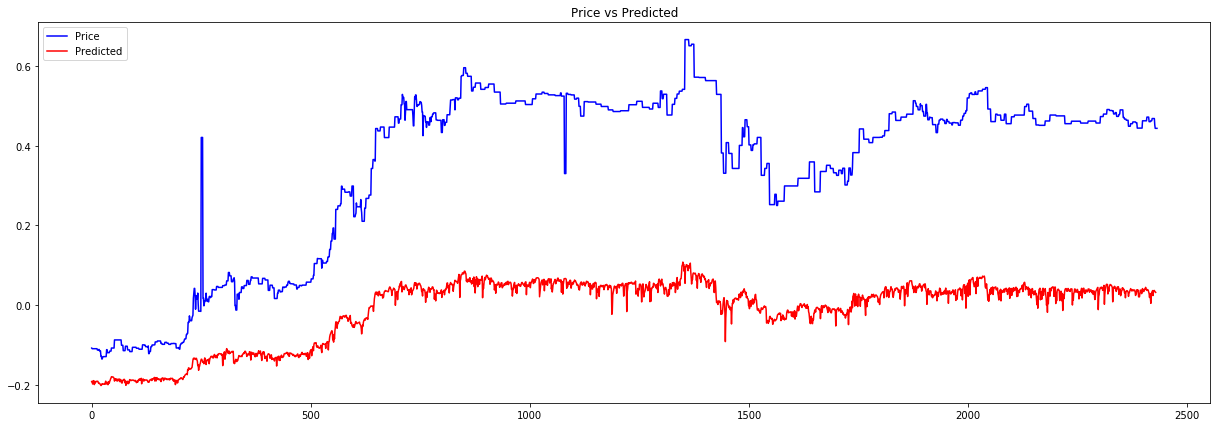

In [242]:
def unnorm(list):
    new_list = []
    for item in list:
#         print type(item)
        new_item = (float(item) + dfNN_mean) * (dfNN_max - dfNN_min)
        new_list.append(new_item)
    return new_item

unnorm_yTest2 = unnorm(yTest2)
unnorm_test_pred_list2 = unnorm(test_pred_list2)

# print yTest2, test_pred_list2

plt.figure(figsize=(21,7))
plt.plot(yTest2,label='Price',color='blue')
plt.plot(test_pred_list2,label='Predicted',color='red')
# plt.plot(unnorm_yTest2,label='Price',color='blue')
# plt.plot(unnorm_test_pred_list2,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()